In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
#from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

#import pickle

In [2]:
colNames = list(range(1024))
colNames.append("label")
df = pd.read_csv('../qsar_oral_toxicity.csv', sep=';',names=colNames)

In [3]:
df

0  1  2  3  4  5  6  7  8  9  ...  1015  1016  1017  1018  1019  1020  \
0     0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1     0  0  1  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2     0  0  0  0  0  0  0  0  0  0  ...     0     0     1     0     0     0   
3     0  0  0  0  0  0  0  1  0  0  ...     0     0     0     0     0     0   
4     0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
...  .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
8987  0  0  0  0  0  0  0  1  0  0  ...     0     0     0     1     0     0   
8988  0  1  0  0  0  1  0  1  0  0  ...     0     0     0     1     0     0   
8989  0  0  0  0  0  0  0  1  0  0  ...     0     0     0     0     0     0   
8990  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
8991  0  0  1  0  0  0  0  0  0  0  ...     1     0     0     0     0     0   

      1021  1022  1023     label  
0        0     0     0  negative  
1        0     0     0  negative  
2        0     0     0  negative  
3        0     0     0  negative  
4        0     0     0  negative  
...    ...   ...   ...       ...  
8987     0     0     0  negative  
8988     0     0     0  negative  
8989     0     1     0  negative  
8990     0     0     0  negative  
8991     0     0     0  negative  

[8992 rows x 1025 columns]

In [4]:
#label 1 is positive; otherwise negative
df = pd.get_dummies(df)
df.drop("label_negative",1,inplace=True)
df = df.rename({"label_positive":"label"},axis=1)

In [5]:
df[df["label"]==1].shape
#according to paper's table, this means we have VT data, with ECFP_1024_02 or ECFP_1024_02R

(741, 1025)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8992 entries, 0 to 8991
Columns: 1025 entries, 0 to label
dtypes: int64(1024), uint8(1)
memory usage: 70.3 MB


In [7]:
df["label"].value_counts()

0    8251
1     741
Name: label, dtype: int64

In [8]:
#train, test split
train, test=train_test_split(df, test_size=0.3, random_state=1)
train.reset_index(drop=True, inplace=True)

In [9]:
#######<--

In [10]:
#outlier detection; doing inside cross validation?
#get each detectors
detector_if = IsolationForest(n_jobs=-1)
detector_lof = LocalOutlierFactor(n_jobs=-1)

predicted_if = detector_if.fit_predict(train)
predicted_lof = detector_if.fit_predict(train)

#count outlier numbers for each
count_if = pd.crosstab(predicted_if, columns='count')["count"][-1]
count_lof = pd.crosstab(predicted_lof, columns='count')["count"][-1]
print("Number of outliers using IF: %d/%d" % (count_if, len(predicted_if)))
print("Number of outliers using LOF: %d/%d" % (count_lof, len(predicted_lof)))

Number of outliers using IF: 145/6294
Number of outliers using LOF: 155/6294


In [11]:
#continue
outliers_if = np.where(predicted_if==-1)
outliers_lof = np.where(predicted_lof==-1)

match_count2 = len(np.intersect1d(outliers_lof, outliers_if))

print("LOF and IF agree on %d out of %d anomalies" % (match_count2, count_if))
#dropping outliers
print(f"Size before dropping outlier(s): {len(train)}")
df_clean = train.drop(np.intersect1d(outliers_lof, outliers_if)).reset_index(drop=True)
print(f"Size after dropping outlier(s): {len(df_clean)}")
train=df_clean.copy()

LOF and IF agree on 125 out of 145 anomalies
Size before dropping outlier(s): 6294
Size after dropping outlier(s): 6169


In [12]:
#######-->

In [13]:
train["label"].value_counts()

0    5651
1     518
Name: label, dtype: int64

In [14]:
#!pip install imblearn

In [15]:
###<--

In [16]:
#upsampling: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#t10
#from imblearn.over_sampling import SMOTE

#smote = SMOTE(random_state=12, sampling_strategy=1)#'minority')
#X_train, y_train = smote.fit_resample(train.drop(["label"],1), train["label"])

#plot_2d_space(X_train, y_train, 'SMOTE over-sampling')
#X_test=test.drop(["label"],1)
#y_test=test["label"]

In [17]:
###-->

In [19]:
#y_train.value_counts()

In [20]:
X_train=train.drop(["label"],1)
y_train=train["label"]

# Optimizing

In [22]:
#https://stackoverflow.com/questions/58815016/cross-validating-with-imblearn-pipeline-and-gridsearchcv

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

def imb_pipeline(clf, X, y, params):

    model = Pipeline([
        ('sampling', SMOTE(random_state=1, sampling_strategy=1)),
        ('classification', clf)
    ])
    #optimizing balanced_accuracy instead of accuracy score bc wee upsampled and have a balanced training set; can check accuracy score later, make suree it is low
    score={'BALANCED_ACCURACY':'balanced_accuracy', 'RECALL':'recall', 'F1':'f1'}

    gcv = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=score, n_jobs=12, refit='AUC')
    gcv.fit(X, y)

    return gcv

def print_scores(grid_result):
    print("Best BALANCED_ACCURACY: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_BALANCED_ACCURACY']
    stds = grid_result.cv_results_['std_test_BALANCED_ACCURACY']
    means2 = grid_result.cv_results_['mean_test_RECALL']
    stds2 = grid_result.cv_results_['std_test_RECALL']
    means3 = grid_result.cv_results_['mean_test_F1']
    stds3 = grid_result.cv_results_['std_test_F1']
    params = grid_result.cv_results_['params']
    print("BALANCED_ACCURACY, RECALL, F1 with PARAMS")
    for mean, std, mean2, std2, mean3, std3, param in zip(means, stds, means2, stds2, means3, stds3, params):
        print("%f (%f), %f (%f), %f (%f) with: %r" % (mean, std, mean2, std2, mean3, std3, param))

In [142]:
from scipy.stats import loguniform

classifiers = LogisticRegression(C=1.0, penalty='l2',
                     random_state=None, tol=0.0001, verbose=0,
                     warm_start=False)

#see solver in https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
params = [{'classification__penalty':['elasticnet'],
          'classification__solver':['saga'],
          'classification__C': loguniform(1e-5, 100)},
          {'classification__penalty':['none','l2'],
          'classification__solver':['newton-cg', 'lbfgs', 'sag','saga'],
          'classification__C': loguniform(1e-5, 100)},
          {'classification__penalty':['l1'],
          'classification__solver':('liblinear','saga'),
          'classification__C': loguniform(1e-5, 100)}
         ]

        
    
#for param, classifier in zip(params, classifiers):
grid_result = imb_pipeline(classifiers, X_train, y_train, params) 

#print
print_scores(grid_result)

Best AUC: 0.833387 using {'classification__C': 1.0}
AUC, RECALL, PRECISION with PARAMS
0.805425 (0.022639), 0.556329 (0.045882), 0.349875 (0.036296) with: {'classification__C': 0.01}
0.827141 (0.018067), 0.490403 (0.043294), 0.428383 (0.031413) with: {'classification__C': 0.1}
0.833387 (0.019292), 0.500131 (0.038115), 0.433446 (0.030174) with: {'classification__C': 1.0}
0.822929 (0.019304), 0.501998 (0.041103), 0.410757 (0.030628) with: {'classification__C': 10}


/Users/huy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [143]:
from scipy.stats import randint

classifiers = RandomForestClassifier(n_estimators=50)

#some selected params in https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
params = {'classification__n_estimators': randint(10, 1000), 'classification__max_depth': randint(10,100),
         'classification__criterion':('gini', 'entropy'), 'classification__max_features':('auto', 'sqrt', 'log2')}
    
#for param, classifier in zip(params, classifiers):
grid_result = imb_pipeline(classifiers, X_train, y_train, params) 

#print
print_scores(grid_result)

Best AUC: 0.892614 using {'classification__max_depth': 70, 'classification__n_estimators': 500}
AUC, RECALL, PRECISION with PARAMS
0.873975 (0.014051), 0.538854 (0.025281), 0.528949 (0.016230) with: {'classification__max_depth': 30, 'classification__n_estimators': 100}
0.881894 (0.017735), 0.548562 (0.030972), 0.530575 (0.033757) with: {'classification__max_depth': 30, 'classification__n_estimators': 300}
0.880854 (0.016917), 0.540795 (0.028038), 0.533157 (0.023224) with: {'classification__max_depth': 30, 'classification__n_estimators': 500}
0.882604 (0.021396), 0.504089 (0.059342), 0.592478 (0.029966) with: {'classification__max_depth': 50, 'classification__n_estimators': 100}
0.888545 (0.015057), 0.511781 (0.042475), 0.578881 (0.028721) with: {'classification__max_depth': 50, 'classification__n_estimators': 300}
0.889052 (0.016521), 0.504033 (0.041399), 0.578591 (0.026625) with: {'classification__max_depth': 50, 'classification__n_estimators': 500}
0.890206 (0.014594), 0.486613 (0.05

In [32]:
import numpy
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import loguniform

#setting up NN model 
def setUpModel(n1, n2, lr=0.001, momentums=0.9):
    #set up and compile a model
    model = keras.Sequential()
    
    model.add(layers.Dense(n1, input_dim=X_train.shape[1], activation="sigmoid"))
    model.add(layers.Dense(n2, activation="sigmoid"))
    model.add(layers.Dense(1, activation="sigmoid")) #1 output layer bc of binary output
    
    model.compile(loss='mse',
         optimizer = keras.optimizers.SGD(momentum=momentums, learning_rate=lr),
         metrics=['accuracy',
             keras.metrics.Recall(name="recall", thresholds=0.3)
                 ])
        
    return model

#create a scikilearn-compatible model
Kmodel = KerasClassifier(build_fn=setUpModel, verbose=0, batch_size=100, epochs=100)
# define the grid search parameters
neurons1 = (5, 10, 15, 20)
neurons2 = (5, 10, 15, 20)
lr = [0.005,0.01,0.05,0.1]
momentum = [0.1, 0.4,0.7,0.9,0.99]
params = {"classification__n1":randint(5,15), "classification__n2":randint(5,15),
         "classification__lr":loguniform(0.0001,10), "classification__momentums": uniform(0.01,0.999999)}

#for param, classifier in zip(params, classifiers):
grid_result = imb_pipeline(Kmodel, X_train, y_train, params) 

#print
print_scores(grid_result)

Best AUC: 0.766972 using {'classification__n1': 3, 'classification__n2': 3}
AUC, RECALL, PRECISION with PARAMS
0.748239 (0.039004), 0.483577 (0.381514), 0.251107 (0.270818) with: {'classification__n1': 2, 'classification__n2': 2}
0.726116 (0.032040), 0.416976 (0.332100), 0.204220 (0.155992) with: {'classification__n1': 2, 'classification__n2': 3}
0.765935 (0.030881), 0.638393 (0.033212), 0.249665 (0.063663) with: {'classification__n1': 3, 'classification__n2': 2}
0.766972 (0.026535), 0.615685 (0.082004), 0.263484 (0.030452) with: {'classification__n1': 3, 'classification__n2': 3}


# Get optimized models' scores

In [33]:
# evaluate the model using a given test condition
#def evaluate_model(cv, model):
#    #pipeline
#    steps=[('scaler',MinMaxScaler()),('model', model)]
#    pipeline = Pipeline(steps=steps)
#    # evaluate the model
#    scores = cross_validate(pipeline, X, y, scoring=['accuracy','precision', 'recall'], cv=cv, n_jobs=-1)
    # return scores
#    return [mean(scores['test_accuracy']),mean(scores['test_precision']),mean(scores['test_recall'])]

# Result (using best parameters)

## Precision, Recall vs Threshold

In [34]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

train["label"].value_counts()

0    5651
1     518
Name: label, dtype: int64

In [42]:
#log
X_test = test.drop(["label"],1)
y_test = test["label"]

log = LogisticRegression(C=1, max_iter=2000)

log.fit(X_train, y_train)

#plot_precision_recall_curve(log, X_test, y_test)

LogisticRegression(C=1, max_iter=2000)

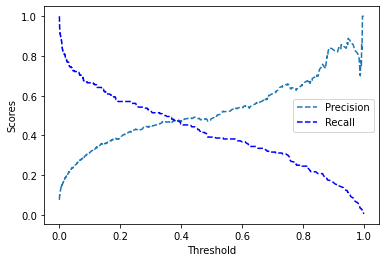

In [43]:
y_scores=log.predict_proba(X_test)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1])
plt.plot(tre, prec[:-1], linestyle='--', label='Precision')
plt.plot(tre, rec[:-1], linestyle='--', color = 'b', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend()
plt.show()

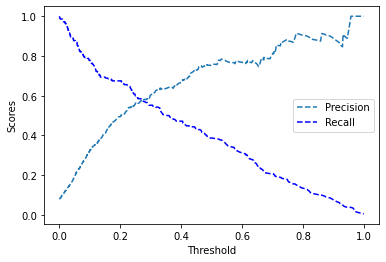

In [45]:
#forest; grid search 2 vars
classifier = RandomForestClassifier(n_estimators=500, max_depth=70)
classifier.fit(X_train, y_train)
#plot_precision_recall_curve(classifier, X_test, y_test)
y_scores=classifier.predict_proba(X_test)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1])
plt.plot(tre, prec[:-1], linestyle='--', label='Precision')
plt.plot(tre, rec[:-1], linestyle='--', color = 'b', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend()
plt.show()

In [79]:
classifier.predict([X_train.iloc[0]])[0]

0

In [76]:
type(X_train.iloc[0])

pandas.core.series.Series

In [78]:
pd.Series([0,1])

0    0
1    1
dtype: int64

In [67]:
def setUpModel(n1=5, n2=5):
    #set up and compile a model
    model = keras.Sequential()
    
    model.add(layers.Dense(n1, input_dim=X_train.shape[1], activation="sigmoid"))
    model.add(layers.Dense(n2, activation="sigmoid"))
    model.add(layers.Dense(1, activation="sigmoid")) #1 output layer bc of binary output
    
    model.compile(loss='mse',
         optimizer = keras.optimizers.SGD(momentum=0.99, learning_rate=0.01),
         metrics=['accuracy',
             keras.metrics.Recall(name="recall", thresholds=0.3)
                 ])
        
    return model

#create a scikilearn-compatible model
Kmodel = KerasClassifier(build_fn=setUpModel, verbose=0, batch_size=100, epochs=100)
Kmodel.fit(X_train, y_train)
#plot_precision_recall_curve(Kmodel, X_test, y_test)

In [68]:
y_train.shape

(6169,)

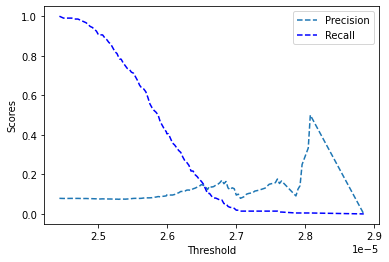

In [69]:
y_scores=Kmodel.predict_proba(X_test)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1])
plt.plot(tre, prec[:-1], linestyle='--', label='Precision')
plt.plot(tre, rec[:-1], linestyle='--', color = 'b', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend()
plt.show()

In [66]:
Kmodel.predict(X_test)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

In [71]:
y_train[y_train==1].shape

(518,)

## ROC

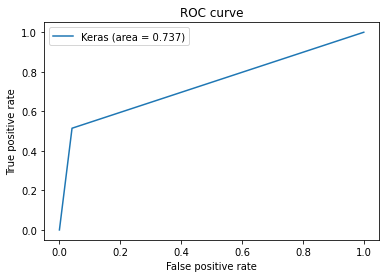

In [59]:
#grid search, inspiration: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

#setting up NN model 
def setUpModel(lr=0.01):
    #set up and compile a model
    model = keras.Sequential()
    
    model.add(layers.Dense(13, input_dim=X_train.shape[1], activation="sigmoid"))
    model.add(layers.Dense(15, activation="sigmoid"))
    model.add(layers.Dense(1, activation="sigmoid")) #1 output layer bc of binary output
    
    model.compile(loss='mse',
         optimizer = keras.optimizers.SGD(momentum=0.99, learning_rate=lr),
         metrics=['accuracy',
             keras.metrics.Recall(name="recall", thresholds=0.3)
                 ])
        
    return model

#create a scikilearn-compatible model
Kmodel = KerasClassifier(build_fn=setUpModel, verbose=0, batch_size=40, epochs=100)
Kmodel.fit(X_train, y_train, epochs=40, batch_size=50, verbose=0)
from sklearn.metrics import roc_curve
y_pred_keras = Kmodel.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test.reset_index(drop=True), y_pred_keras, pos_label=2$)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
#plot_precision_recall_curve(Kmodel, X_test, y_test)
plt.figure(1)
#plt.xlim(0, 0.2)
#plt.ylim(0.8, 1)
#plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [61]:
fpr_keras

array([0.        , 0.04144578, 1.        ])

In [60]:
y_pred_keras

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [44]:
Kmodel.predict_proba(X_test)

AttributeError: 'KerasClassifier' object has no attribute 'model'

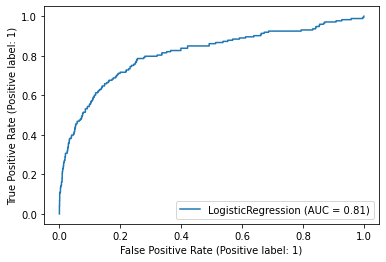

In [39]:
plot_roc_curve(log, X_test, y_test)

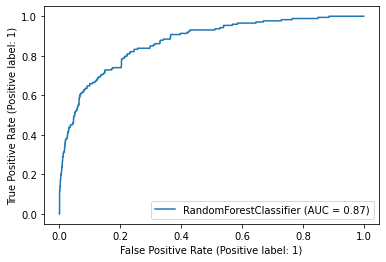

In [40]:
plot_roc_curve(classifier, X_test, y_test)

In [43]:
plot_roc_curve(Kmodel, X_test, y_test)

ValueError: KerasClassifier should be a binary classifier

In [ ]:
len("")